In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf ##  Autocorrelation plot
from sklearn import preprocessing  ## for standardization 
import pystan_utils
import pystan

In [2]:
df=pd.read_csv("pickups+weather_wallstreet.csv")
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


### Data preparation

In [3]:
## data type
df.dtypes

datetime          object
pickups            int64
date              object
min_temp         float64
max_temp         float64
wind_speed       float64
wind_gust        float64
visibility       float64
pressure         float64
precipitation    float64
snow_depth       float64
fog                int64
rain_drizzle       int64
snow_ice           int64
thunder            int64
dtype: object

In [4]:
## Convert datetime column into datetime object
df["datetime"]=pd.to_datetime(df["datetime"],format="%Y-%m-%d")

## Adding columns with day of week(dow) and time of day(tod)
df["dow"]=df.datetime.dt.weekday
df["tod"]=df.datetime.dt.hour

## Adding time of day and day of week as dummy variables
dummy_week=pd.get_dummies(df["dow"])
dummy_hour=pd.get_dummies(df["tod"])
week_colName = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dummy_week.set_axis(week_colName, axis=1, inplace=True)

new_df=pd.concat([df, dummy_week,dummy_hour],axis=1).set_index("datetime").drop(["date","tod","dow"],axis=1)
print(new_df.shape)
print(new_df.columns)

(65712, 44)
Index([      'pickups',      'min_temp',      'max_temp',    'wind_speed',
           'wind_gust',    'visibility',      'pressure', 'precipitation',
          'snow_depth',           'fog',  'rain_drizzle',      'snow_ice',
             'thunder',        'Monday',       'Tuesday',     'Wednesday',
            'Thursday',        'Friday',      'Saturday',        'Sunday',
                     0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23],
      dtype='object')


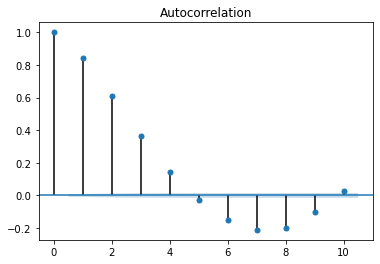

In [5]:
## Autocorrelation plot: how many lags should be included ...?
plot_acf(new_df.pickups,lags=10);

## Adding first and second lagged_pickups to the dataset
new_df["first_lag"]=new_df.pickups.shift(1)
new_df["second_lag"]=new_df.pickups.shift(2)
new_df.dropna(inplace=True)

In [6]:
new_df.shape

(65710, 46)

In [8]:
# Get column names first
names = new_df.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(new_df)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [9]:
## Predictors and target variable as matrix
X = scaled_df.drop("pickups",axis=1).values
y = scaled_df["pickups"].values


# Mean and standard deviation of pickups: to convert back to the orginal data
y_std = new_df.pickups.std()
y_mean = new_df.pickups.mean()

In [10]:
## The first 2/3 as train set and rest 1/3 as test set
N,D = X.shape
split = int(N*2/3)
X_train = X[:split,:]; X_test = X[split:, :]
y_train = y[:split]; y_test = y[split:]

In [11]:
# funciton for evaluating the quality of the predictions of a regression model (continuous output variables!)
def compute_error(trues, predicted):
    trues=trues.flatten()
    predicted=predicted.flatten()
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

### Plate notation

![title](PGM_Heteroscedastic.png)

### Stan model : Heteroscedastic regression model

We assume that the Gaussian likelihood was indeed the most appropriate choice. In many problems of interest, it is often the case that constant observation variance ($\sigma^2$) is too limiting or inadequate. We can relax this assumption by considering heteroscedastic models, in which the observation variance is assumed to be non-constant and dependent on a set of arbitrary features $u$ (e.g. time of the day)

$y_n \sim \mathcal{N}(\alpha + \boldsymbol\beta^T \textbf{x}_n , exp(\eta^T  \textbf{u}_n))$

Where $\eta$ is a new set of coefficients to parameterize the relation between the features $u$ and the observation noise.

As with the Poisson, we use a log link function to ensure non-negative :

$exp(\eta^T  \textbf{u}_n)\in (\infty , 0) $

Lets implement this model in STAN!

**In this particular case**: we assume that the observation variance is also linearly dependent on the inputs $\textbf{x}$.

In [12]:
## define STAN model
STAN_Hetro_model = """
data {
    int<lower=1> N;                       // no. of data items
    int<lower=1> D;                       // no. of predictors
    real y[N];                            // target variable
    matrix[N,D] X;                       // predictor matrix 
}
parameters {
    real alpha1;                          // first intercept 
    real alpha2;                          // second intercept 
    vector[D] beta1;                      // coefficients for predictors
    vector[D] beta2;                      // coefficients 
}

model {    
    // Important: In STAN, the second parameter of “normal(0, 10)" is a standard
    // deviation and not a variance! So, the variance is actually 10^2 = 100
    alpha1 ~ normal(0,10);                // prior on the first intercept
    alpha2 ~ normal(0,10);                // prior on the second intercept
    beta1 ~ normal(0,1);                  // prior on the coefficients for predictors 
    beta2 ~ normal(0,1);                  // prior on the coefficients 
    y ~ normal(alpha1 + X * beta1, exp(alpha2 + X * beta2)); // likelihood
 }

"""

# compile model
sm = pystan.StanModel(model_code = STAN_Hetro_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5eb71bc076d25e93edcf5c5c0e90e8a2 NOW.


### Inference on the model using MCMC (NUTS) on a small subsample of the dataset

In [13]:
# prepare data for Stan model
X_train_small = X_train[:1000,:]
y_train_small = y_train[:1000]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'X': X_train_small, 'y': y_train_small}

In [15]:
%%time
fit = sm.sampling(data=data, iter=1000, chains=2, algorithm="NUTS", 
                  seed=42, control={"max_treedepth" : 30}, verbose=True)
print(fit)

Inference for Stan model: anon_model_5eb71bc076d25e93edcf5c5c0e90e8a2.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

             mean se_mean     sd   2.5%     25%     50%     75%   97.5%  n_eff   Rhat
alpha1      -0.11  1.3e-3   0.05   -0.2   -0.14   -0.11   -0.08   -0.02   1296    1.0
alpha2      -1.39  2.7e-3    0.1  -1.59   -1.45   -1.38   -1.32   -1.18   1467    1.0
beta1[1]    -0.01  8.5e-4   0.03  -0.08   -0.03   -0.01  8.2e-3    0.05   1413    1.0
beta1[2]   9.6e-3  8.0e-4   0.03  -0.05 -9.5e-3  9.7e-3    0.03    0.07   1399    1.0
beta1[3]  -3.0e-3  2.4e-4   0.01  -0.03   -0.01 -2.9e-3  4.6e-3    0.02   2120    1.0
beta1[4]   3.7e-3  3.0e-4   0.01  -0.02 -3.9e-3  3.9e-3    0.01    0.02   1380    1.0
beta1[5]  -1.1e-3  4.8e-4   0.02  -0.04   -0.01 -1.4e-3    0.01    0.03   1445    1.0
beta1[6]  -1.7e-3  2.6e-4 9.1e-3  -0.02 -7.9e-3 -1.2e-3  4.1e-3    0.02   1260    1.0
beta1[7]  -9.3e-3  7.3e-4   0.02  -0.06

Plot the posterior distribution of some of the latent variables in the model (alpha, betas and sigma)

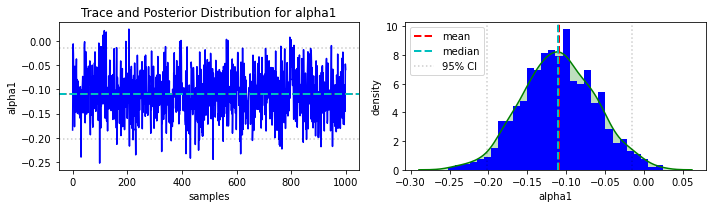

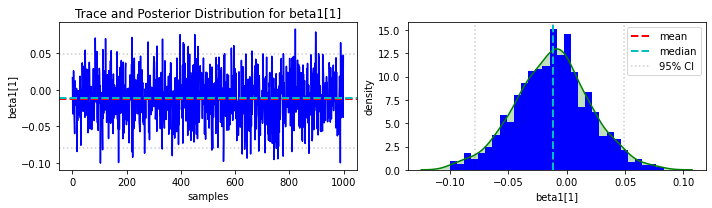

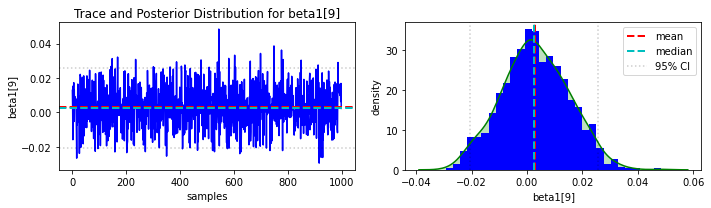

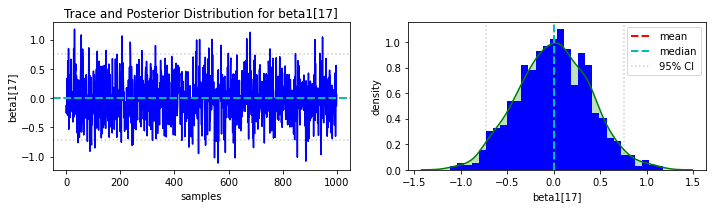

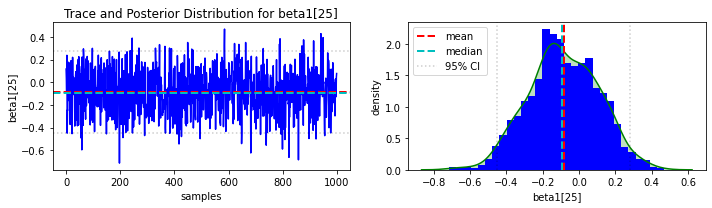

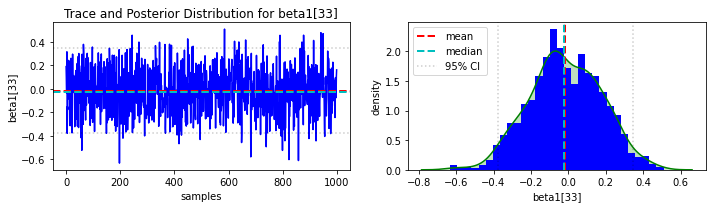

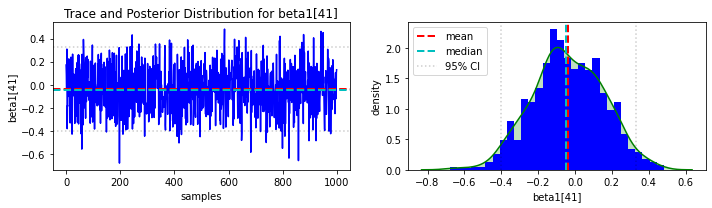

In [17]:
plt.rcParams["figure.figsize"]=(10,3)
pystan_utils.plot_trace(fit["alpha1"],"alpha1")
plt.show()
for i in range(1,D,8):
    pystan_utils.plot_trace(fit["beta1[%d]"%i],"beta1[%d]"%i)
    plt.show()    

In [19]:
samples = fit.extract(permuted=True)  # return a dictionary of arrays
y_hat = np.mean(samples["alpha1"].T + np.dot(X_test, samples["beta1"].T), axis=1)

# convert back to the original scale
preds = y_hat * y_std + y_mean
y_true = y_test * y_std + y_mean

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.901
MAE: 15.232
RMSE: 20.734
R2: 0.796


In [22]:
sigma_hat = np.mean(np.exp(samples["alpha2"].T + np.dot(X_test, samples["beta2"].T)), axis=1)
sigma_hat

array([0.4517858 , 0.17268204, 0.26143988, ..., 0.30036389, 0.32173016,
       0.28487559])

### STAN: Train on full dataset using ADVI (Automatic Differentiation Variational Inference)
MCMC methods have great properties, namely the fact that in the limit of infinite computation time they will converge to the true posterior distribution. However, they often have difficulty scaling to larger datasets. 

ADVI on the other hand is much more scalable. Let us now try to use ADVI to perform inference in our model

In [20]:
# prepare data for Stan model
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'X': X_train_small, 'y': y_train_small}

In [ ]:
%%time
# prepare data for Stan model
N, D = X_train.shape
data = {'N': N, 'D': D, 'X': X_train, 'y': y_train}
fit = sm.vb(data=data, iter=5000, algorithm="meanfield", grad_samples=200, seed=42, verbose=True)

#### Extract results and compute error statistics:

Using the estimated values, we can make predictions for the test set:

In [43]:
samples =fit.extract(permuted=True)
alpha = samples["alpha"]
beta = samples["beta"]

In [44]:
y_hat = (np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1))
y_hat

preds = y_hat 
y_true = y_test 

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.907
MAE: 14.645
RMSE: 19.550
R2: 0.819


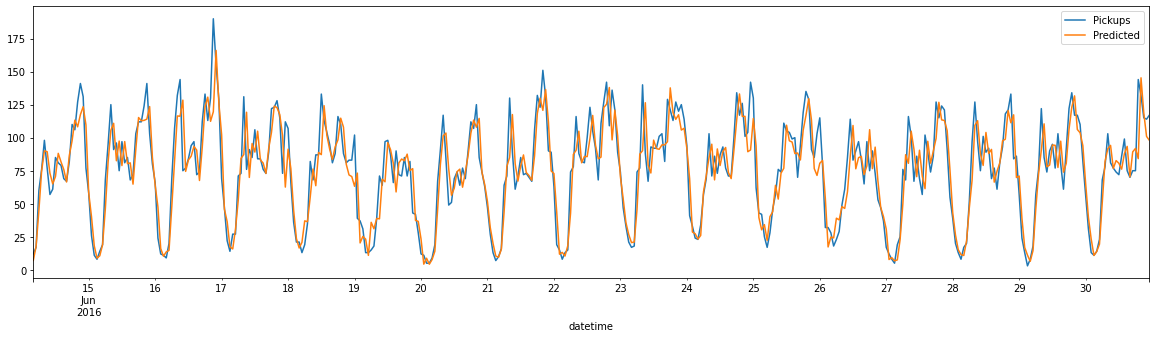

In [45]:
test_dataset = pd.DataFrame({"Pickups":y_true.flatten(),"Predicted":preds}).set_index(new_df.index[split:])
test_dataset.iloc[21500:,:].plot(figsize=(20,5));